# COS 424 Homework 2 Demo

In [1]:
import math
import numpy as np 
from sklearn import tree
from IPython.display import Image  
from sklearn.externals.six import StringIO
#import pydot
import pandas
import os
# Enter your directory here
os.chdir('/Users/brian_jo/Desktop/Project/COS424_2016/methylation_imputation')

## Data import: writing a parser

One approach to importing the dataset can be to write a custom parser that reads in the data in your preferred format: (we will discuss an alternate approach later) 

In [57]:
# utility functions to parse chromosome files

# parse training file
def parseTrainFile(filename='data/intersected_final_chr1_cutoff_20_train.bed'):
    # open train file
    flTestTissue = open(filename, 'r')
    lines = flTestTissue.readlines()
    flTestTissue.close()

    # example of a line
    # chr1	10562	10564	+	0.82051283	0.962963	0.9305556	0.79591835	0.9315069	0.92941177	0.975	0.9569892	0.8125	nan	0.8518519	0.8518519	0.95454544	0.8684211	0.9661017	0.8630137	0.8679245	0.9230769	0.8372093	0.9326923	0.9425287	0.975	0.93670887	0.9491525	0.9425287	nan	nan	0.8695652	0.87931037	0.88235295	0.92941177	0.9705882	0.90625	0

    # parse lines
    lineIndex = 0
    dLocPredVals = {}
    for line in lines:
	items = line[:-1].split('	')
	chrom = items[0]
	locStart = int(items[1])
	locEnd = int(items[2])
	sign = items[3]
	methVals = [float(a) for a in items[4:]]	
	x = np.all(np.isnan(methVals))
	#print x
        locPair = (lineIndex, locStart, locEnd)
	dLocPredVals[locPair] = np.array(methVals) 
	lineIndex +=1
    return dLocPredVals;

    
# parse predictor file    
def parsePartialFullFile(filename='data/intersected_final_chr1_cutoff_20_sample_partial.bed'):
    # open partial file
    flTestTissue = open(filename, 'r')
    lines = flTestTissue.readlines()
    flTestTissue.close()

    # chr1	100508463	100508465	+	      nan	0
    # chr1	546983	           546985	+	0.8518519	1
    
    # parse lines
    lPairs = []
    trainingIndices = []
    testingIndices = []
    lineIndex = 0
    for line in lines:
	#print line
	items = line[:-1].split('	')
	chrom = items[0]
	locStart = int(items[1])
	locEnd = int(items[2])
	strand = items[3]
	methValStr = items[4]
	#print items[4]
	if methValStr == 'nan':
	    methVal = -2.0;
	    testingIndices.append(lineIndex)
	else:
	    methVal = float(methValStr)
	    trainingIndices.append(lineIndex)
	locPair = [lineIndex, locStart, locEnd,methVal]
	lPairs.append(locPair)
	lineIndex +=1;
    lPairs = np.array(lPairs)
    return lPairs,testingIndices, trainingIndices
	

In [58]:
# parse partial file
lPairs,testingIndices, trainingIndices = parsePartialFullFile()
print "Number of testing indices " + str(len(testingIndices))
print "Number of training indices " + str(len(trainingIndices))

Number of testing indices 372028
Number of training indices 7523


In [59]:
# parse training file
dLocPredVals = parseTrainFile()
print len(dLocPredVals.values())
print len(testingIndices) + len(trainingIndices)

379551
379551


In [60]:
# replace nan-entries of the traininig data arrays by averages
allStacked = np.array(dLocPredVals.values())
colMeans = np.nanmean(allStacked,axis=0)

#http://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns
#Find indicies that you need to replace
inds = np.where(np.isnan(allStacked))
#Place column means in the indices. Align the arrays using take
allStacked[inds]=np.take(colMeans,inds[1])

# lets see how the data loots line
print allStacked.shape
print allStacked[testingIndices[0],:]
print lPairs[trainingIndices[0]]

(379551, 34)
[ 0.9148936   0.9268293   0.96153843  0.8867925   0.921875    0.88709676
  0.89830506  0.9701493   0.94545454  0.8913044   0.93939394  0.8965517
  0.9047619   0.6875      0.9189189   0.94871795  0.9230769   0.94285715
  0.884058    0.93939394  0.87096775  0.9183673   0.8947368   0.82608694
  0.84444445  0.68795432  0.60750366  0.8         0.72911892  0.94736844
  0.9322034   0.8636364   0.9574468   0.        ]
[  1.08400000e+03   5.34241000e+05   5.34243000e+05   6.88888900e-01]


In [61]:
# extract training indices
X = np.take(allStacked,trainingIndices,axis=0)
Y = np.take(lPairs,trainingIndices,axis=0)
Y = Y[:,3] # take the leftmost column
print X.shape
print Y.shape

(7523, 34)
(7523,)


## Testing out a simple method: Decision Tree?

Will creating a decision tree be a good approach for this problem? In this approach, we train a regression decision tree as our model. This model splits the data into a tree and fits a linear repression model at each leaf. The main motivation is that this model can simultaneously select features and tune linear regression models at each leaf, i.e. can explain non-linear relationships between input and output variables. Finally, it provides an explanation of the model through a visual tree.

In [62]:
# train a regression decision tree classifier on the first 10 training entries
# http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

clf = tree.DecisionTreeRegressor(max_depth=10)
clf = clf.fit(X[0:1000], Y[0:1000])

In [63]:
# fit decision tree to all of data
clf_all = clf.fit(X, Y)

In [ ]:
# draw decision tree - Keep in mind that you need to have pydot installed!
from IPython.display import Image  
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  
#graph.write_pdf("dd.pdf") 

In [64]:
# extract testing data
# compare to existing values from the full file
lPairs_all,_,_ = parsePartialFullFile('data/intersected_final_chr1_cutoff_20_sample_full.bed')
print lPairs_all.shape

(379551, 4)


In [65]:
# some of the methylation values are not known, so we take care to filter those out
# extract indices where values exist
values_exist = np.where(lPairs_all[:,3]!=-2.0)[0]
# find the trsting indices for which values exist
final_testing_indices = np.intersect1d(values_exist, testingIndices)
print "Number of indices for which values exist: " + str(len(values_exist))
print "Number of testing indices: " + str(len(testingIndices))
print "Number of testing indices: " + str(len(final_testing_indices)) 

Number of indices for which values exist: 375934
Number of testing indices: 372028
Number of testing indices: 368411


In [67]:
# extract the known values for testing
Y_test1 = np.take(lPairs_all,final_testing_indices,axis=0)[:,3]
print "Known values shape: " + str(Y_test1.shape)

# extract testing data features for prediction
X_test1 = np.take(allStacked,final_testing_indices,axis=0)
print "Test feature vectors shape: " + str(X_test1.shape)

predictions = clf.predict(X_test1)

# print predictions
print "Predictions: "
print predictions
print "Ground Truth: "
print Y_test1


Known values shape: (368411,)
Test feature vectors shape: (368411, 34)
Predictions: 
[ 0.74566285  0.74566285  0.74566285 ...,  0.78181282  0.74566285
  0.74566285]
Ground Truth: 
[ 0.9137931   0.9318182   0.91752577 ...,  0.89772725  0.87341774
  0.96103895]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9086
Date:                Thu, 03 Mar 2016   Prob (F-statistic):              0.340
Time:                        18:18:16   Log-Likelihood:             4.8586e+05
No. Observations:              368411   AIC:                        -9.717e+05
Df Residuals:                  368409   BIC:                        -9.717e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.7421      0.001   1435.228      0.0

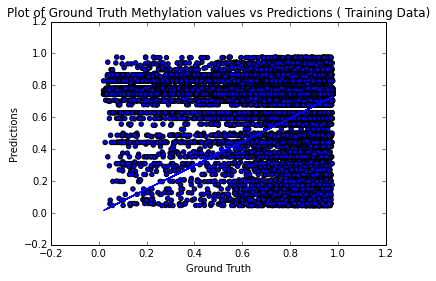

In [69]:
# fit a linear regression line
# http://stackoverflow.com/questions/19068862/how-to-overplot-a-line-on-a-scatter-plot-in-python
import statsmodels.api as sm
xs = Y_test1
ys = predictions
results = sm.OLS(ys,sm.add_constant(xs)).fit()

print results.summary()

plt.scatter(xs,ys)

#X_plot = np.linspace(0,1,100)
plt.plot(xs, xs*results.params[0] + results.params[1])
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Plot of Ground Truth Methylation values vs Predictions ( Training Data)')
plt.show()

In [70]:
# compute mean squared error
mean_sq_error = np.mean((Y_test1-predictions)**2)
print mean_sq_error
print "sqrt: " + str(np.sqrt(mean_sq_error))

0.0363286795224
sqrt: 0.1906008382


In [74]:
np.corrcoef(Y_test1,predictions)

array([[ 1.        ,  0.00157048],
       [ 0.00157048,  1.        ]])

As you can see, with RMSE = 0.191 and r = 0.002, this is not performing as well as we would like... Let's start over, shall we?

## Alternate method for Data import: pandas

### [pandas](http://pandas.pydata.org/) is a python package that is aimed at dealing with data inputs that are well-organized, such as the .bed files that we have.

For more information about various useful functionalities of pandas, go here:

http://pandas.pydata.org/pandas-docs/stable/index.html

You will also find a lot of helpful questions and answers that have been discussed in StackOverflow (simply google your question, and most likely, the top search results will be StackOverflow discussion threads).

In [2]:
# read_csv() function needs the parameter sep to tell it what your separator is
train_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_train.bed', sep='\t', header=None)
sample_p_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_partial.bed', sep='\t', header=None)
sample_f_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_full.bed', sep='\t', header=None)

In [9]:
# head() function outputs the first n rows of your data
train_bed.head(n = 10)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,chr1,10468,10470,+,0.750000,0.681818,0.888889,0.518518,0.866667,0.971429,...,0.945946,NaN,NaN,0.875000,0.949152,0.861111,0.760000,NaN,0.437500,0
1,chr1,10492,10494,+,0.882353,0.705882,0.918367,0.842105,0.935484,0.964286,...,0.925532,NaN,NaN,0.909091,0.942529,0.814815,0.757576,NaN,0.660377,0
2,chr1,10496,10498,+,0.849315,0.843137,0.847458,0.883721,0.913043,0.922222,...,0.951456,NaN,NaN,0.916667,0.947917,0.918033,0.894737,0.921569,0.852459,0
3,chr1,10541,10543,+,0.868132,0.941176,0.939024,0.949152,0.956989,0.933333,...,0.889908,NaN,NaN,0.947368,0.684211,0.857143,0.916667,0.959459,0.974683,0
4,chr1,10562,10564,+,0.820513,0.962963,0.930556,0.795918,0.931507,0.929412,...,0.942529,NaN,NaN,0.869565,0.879310,0.882353,0.929412,0.970588,0.906250,0
5,chr1,10576,10578,+,0.661017,0.775510,0.887097,0.583333,0.880000,0.927536,...,0.878378,NaN,NaN,0.733333,0.945455,0.821429,0.742857,0.961538,0.777778,0
6,chr1,10578,10580,+,0.711864,0.804348,0.783333,0.676471,0.913043,0.941176,...,0.942857,NaN,NaN,0.857143,0.814815,0.764706,0.805970,0.918367,0.750000,0
7,chr1,10661,10663,+,0.765957,0.714286,0.647059,0.821429,0.851064,0.714286,...,NaN,NaN,NaN,NaN,0.934783,0.788462,0.658537,0.864865,0.521739,0
8,chr1,10669,10671,+,0.866667,0.892857,0.891304,0.944444,0.905660,0.762712,...,NaN,NaN,NaN,NaN,0.967742,0.949152,0.900000,0.931818,0.875000,0
9,chr1,10688,10690,+,0.897436,0.880952,0.867925,0.958333,0.900000,0.737500,...,0.964286,NaN,NaN,NaN,0.976744,0.888889,0.846154,0.936508,0.820513,0


In [10]:
sample_f_bed.head(n = 10)

,0,1,2,3,4,5
0,chr1,10468,10470,+,0.913793,0
1,chr1,10492,10494,+,0.931818,0
2,chr1,10496,10498,+,0.917526,0
3,chr1,10541,10543,+,0.933884,0
4,chr1,10562,10564,+,0.936842,0
5,chr1,10576,10578,+,0.951219,0
6,chr1,10578,10580,+,0.897436,0
7,chr1,10661,10663,+,0.862745,0
8,chr1,10669,10671,+,0.939394,0
9,chr1,10688,10690,+,0.965517,0


The format of these .bed files are discussed in the github repo readme, as well as the assignment PDF.

In [3]:
# You can refer to each *column* of the datatable by index:
test_indeces = sample_p_bed[5]==1
train_indeces = sample_p_bed[5]==0
print(sum(test_indeces))
print(np.where(test_indeces))

7610
(array([  1084,   1154,   1214, ..., 379252, 379258, 379368]),)


There are 7610 positions (out of total 379551) where the last column entry is 1 (the positions that are observed in the 450K BeadChip).

Now, let's try taking the mean of each row (mean methylation value across tissues at a location in chr1):

In [12]:
# mean() function with axis = 1 takes row-wise averages.
train_bed[list(range(4,37))].mean(axis=1)

0         0.782426
1         0.836918
2         0.897671
3         0.913804
4         0.907181
5         0.801933
6         0.809198
7         0.698955
8         0.889537
9         0.864452
10        0.724535
11        0.881583
12        0.894980
13        0.885859
14        0.724211
15        0.884685
16        0.808047
17        0.896089
18        0.892571
19        0.704055
20        0.783236
21        0.711146
22        0.391053
23        0.235756
24        0.141029
25        0.388317
26        0.342627
27        0.643686
28        0.468989
29        0.426951
            ...   
379521    0.814346
379522    0.893050
379523    0.889165
379524    0.903788
379525    0.750231
379526    0.825168
379527    0.830262
379528    0.788398
379529    0.864323
379530    0.918622
379531    0.730308
379532    0.890458
379533    0.812594
379534    0.880824
379535    0.825518
379536    0.842819
379537    0.848609
379538    0.800425
379539    0.886900
379540    0.888341
379541    0.904936
379542    0.

You can see that the averages are all ratios (between 0 and 1).

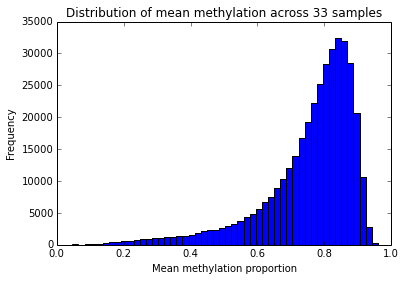

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

# the histogram of the data
plt.hist(train_bed[list(range(4,37))].mean(axis=1).tolist(), 50)

plt.xlabel('Mean methylation proportion')
plt.ylabel('Frequency')
plt.title('Distribution of mean methylation across 33 samples')

plt.show()

## How good is the mean approximation?

We can ask a very naive question: how good is the mean approximation for imputation? In this case, we just fill in the test files with the mean of 33 samples, and see how well the approximation performs.

In [5]:
# Let's take indices of the sample file that aren't nans for comparison:
# By the way, learning the python list comprehension construction is totally worth it.
# Check out http://www.secnetix.de/olli/Python/list_comprehensions.hawk if the following code confuses you.

not_nans_in_full = ~np.isnan(sample_f_bed[4])
test_indeces_nan_filtered = [test_indeces[x] and not_nans_in_full[x] for x in range(len(test_indeces))]

print(sum(test_indeces_nan_filtered))

train_indeces_nan_filtered = [train_indeces[x] and not_nans_in_full[x] for x in range(len(train_indeces))]

print(sum(train_indeces_nan_filtered))

7523
368411


In [6]:
# Python list comprehension keeps coming up...
row_means = train_bed[list(range(4,37))].mean(axis=1)
test_indeces_nan_filtered_numeric = np.where(test_indeces_nan_filtered)[0]

row_means_test = [row_means[x] for x in test_indeces_nan_filtered_numeric]
partial_values_test = [sample_f_bed[4][x] for x in test_indeces_nan_filtered_numeric]

np.corrcoef(row_means_test, partial_values_test)

array([[ 1.        ,  0.79374181],
       [ 0.79374181,  1.        ]])

Among test values (7523 of them, we are seeing r = 0.79 and r^2 = 0.63).

In [7]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

print(rmse(np.array(row_means_test), np.array(partial_values_test)))

0.157066842941


And RMSE = 0.16. Let's see how well this generalizes to the rest of the test set, using the same method.

In [8]:
train_indeces_nan_filtered_numeric = np.where(train_indeces_nan_filtered)[0]

row_means_test = [row_means[x] for x in train_indeces_nan_filtered_numeric]
full_values_test = [sample_f_bed[4][x] for x in train_indeces_nan_filtered_numeric]

print(np.corrcoef(row_means_test, full_values_test))
print(rmse(np.array(row_means_test), np.array(full_values_test)))

[[ 1.          0.77229991]
 [ 0.77229991  1.        ]]
0.11748933978


We are seeing r = 0.772 (r^2 = 0.596), and RMSE = 0.117. This is not an excellent prediction (as you could probably guess), but let's see what happened with an informative graph:

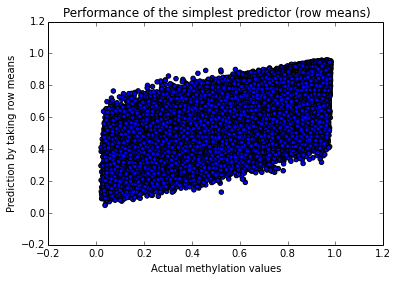

In [52]:
%matplotlib inline

plt.scatter(full_values_test, row_means_test)

plt.xlabel('Actual methylation values')
plt.ylabel('Prediction by taking row means')
plt.title('Performance of the simplest predictor (row means)')

plt.show()

This graph actually could have an interesting interpretation: at any given location with actual methylation values (slicing the graph vertically), there is a distribution of means across other tissues. Is this distribution roughly Gaussian? Or is it some other distribution? You can probe further to find out! You may come across interesting conclusions, but this is not in the scope of this assignment.

## Let's try one other very simple approach - imputation by similarity

There is another very naive hypothesis we can test: that the imputation values will roughly follow the pattern of the most similar tissue. The simplest way to implement this is to simply fill in all values with the methylation value of the closest tissue. (more sensible methods will take some weighted average among the 33 known tissues, *hint* *hint* ;) )

In [53]:
# we have partial_values_test defined from above:
for i in range(4,37):
    test_array = [train_bed[i][x] for x in test_indeces_nan_filtered_numeric]
    test_array_mod = [test_array[x] for x in range(len(test_array)) if ~np.isnan(test_array[x])]
    temp_partial_values_test = [partial_values_test[x] for x in range(len(partial_values_test)) if ~np.isnan(test_array[x])]
    print("Sample " + str(i) + " has r = ")
    print(np.corrcoef(test_array_mod, temp_partial_values_test)[0,1])


Sample 4 has r = 
0.378598417584
Sample 5 has r = 
0.345252677334
Sample 6 has r = 
0.361315960374
Sample 7 has r = 
0.317478997909
Sample 8 has r = 
0.747913758746
Sample 9 has r = 
0.800082923738
Sample 10 has r = 
0.819903104044
Sample 11 has r = 
0.726106574721
Sample 12 has r = 
0.622060560327
Sample 13 has r = 
0.415857835124
Sample 14 has r = 
0.489532506005
Sample 15 has r = 
0.530428055146
Sample 16 has r = 
0.49737091449
Sample 17 has r = 
0.456762207392
Sample 18 has r = 
0.42315902776
Sample 19 has r = 
0.452502097166
Sample 20 has r = 
0.472791940205
Sample 21 has r = 
0.595136127269
Sample 22 has r = 
0.468653133869
Sample 23 has r = 
0.958137133375
Sample 24 has r = 
0.903443669227
Sample 25 has r = 
0.907276390419
Sample 26 has r = 
0.901410887449
Sample 27 has r = 
0.881939901448
Sample 28 has r = 
0.870240568323
Sample 29 has r = 
0.285251817427
Sample 30 has r = 
0.746240943036
Sample 31 has r = 
0.748603867482
Sample 32 has r = 
0.561316455818
Sample 33 has r = 
0.4

Our test sample is very similar to sample 23 (r = 0.958!!). Let's fill in our predictions with values from sample 23 and see what happens:

In [9]:
samp_23_test = [train_bed[23][x] for x in train_indeces_nan_filtered_numeric]
full_values_test = [sample_f_bed[4][x] for x in train_indeces_nan_filtered_numeric]

# Need to take out nans. However, in the real assignment, you must fill in the nans with some value for full imputation:
samp_23_test_mod = [samp_23_test[x] for x in range(len(samp_23_test)) if ~np.isnan(samp_23_test[x])]
full_values_test_mod = [full_values_test[x] for x in range(len(samp_23_test)) if ~np.isnan(samp_23_test[x])]

print(np.corrcoef(samp_23_test_mod, full_values_test_mod))
print(rmse(np.array(samp_23_test_mod), np.array(full_values_test_mod)))

[[ 1.          0.92177299]
 [ 0.92177299  1.        ]]
0.0670191751457


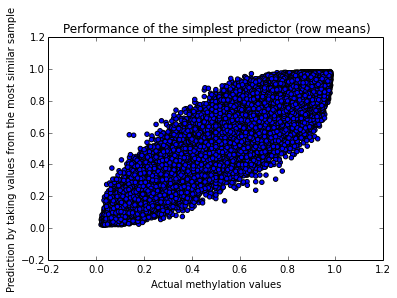

In [10]:
%matplotlib inline

plt.scatter(full_values_test_mod, samp_23_test_mod)

plt.xlabel('Actual methylation values')
plt.ylabel('Prediction by taking values from the most similar sample')
plt.title('Performance of the simplest predictor (row means)')

plt.show()

Even using this simple approach to use existing information from the sample_partial file provides a much better result (r = 0.922, r^2 = 0.850, RMSE = 0.067). Therefore, you can guess that from your assignment, we are generally expecting a result that is better than this, although we will not necessarily grade on accuracy of your imputation.

## Incorporating genetic and epigenetic information

As you might be aware, the genome is not a random sequence of A,T,C,G's. There are a lot of information that is buried in the genome (a lot of which we still don't have a good understanding), and using annotations from previous experiments can help in analyses of studies that involving genetic sequences.

For this exercise, we will import [ENCODE](https://www.encodeproject.org/) annotations of the genome into the pipeline. ENCODE outlines the putative regulatory elements in the genome that have been identified by a set of experiments. Since DNA methylation is an epigenetic feature, this set of information may give us a better understanding of the distribution of likely methylation sites.

First, I navigate to ENCODE portal in UCSC genome browser:

https://genome.ucsc.edu/ENCODE/downloads.html

And want to incorporate information from transcription factor binding sites (Txn Factor ChIP):

http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeRegTfbsClustered/

In [4]:
# Note: this code assumes that you downloaded the Transcription factor database from ENCODE under ./annotations/
txn_factors = pandas.read_csv('annotations/wgEncodeRegTfbsClusteredV3.bed', sep='\t', header=None)

In [5]:
txn_factors.head(n = 10)

,0,1,2,3,4,5,6,7
0,chr1,10073,10329,ZBTB33,354,2,"204,246","354,138"
1,chr1,10149,10413,CEBPB,201,1,343,201
2,chr1,16110,16390,CTCF,227,7,"213,612,621,627,628,631,662","110,139,171,209,227,200,170"
3,chr1,29198,29688,TAF1,184,1,157,184
4,chr1,29275,29591,GABPA,198,1,180,198
5,chr1,89795,90051,USF1,185,2,"68,202","146,185"
6,chr1,91156,91580,CTCF,223,9,"9,640,645,657,663,669,672,675,685","183,223,138,115,115,145,141,144,220"
7,chr1,104859,105089,CTCF,106,2,"48,49","87,106"
8,chr1,138850,139274,CTCF,166,3,"24,213,679","166,125,127"
9,chr1,235541,235877,SP1,120,1,196,120


You can see that this file is also in bed format. You don't have to pay too much attention columns after 4 (it outlines details of the experimental evidence of this transcription factor). You are familiar with columns 0, 1 and 2, and column 3 outlines which transcription factor binds to this location.

In [6]:
# set() function takes the unique values from an array. There are 161 distinct TFs in this table.
print(set(txn_factors[3]))
print(len(set(txn_factors[3])))

set(['HSF1', 'SMARCC2', 'SMARCC1', 'POLR3G', 'MAFK', 'CCNT2', 'MAFF', 'ZNF143', 'BHLHE40', 'SIX5', 'HDAC6', 'BCLAF1', 'ZNF263', 'MYC', 'SETDB1', 'BRCA1', 'TRIM28', 'SP1', 'SP2', 'SP4', 'CREB1', 'ESRRA', 'NR2C2', 'GATA2', 'GATA3', 'GATA1', 'GTF2F1', 'RFX5', 'MAZ', 'RBBP5', 'FOXA1', 'RUNX3', 'ELK1', 'POU2F2', 'TCF12', 'CTBP2', 'MTA3', 'KDM5A', 'KDM5B', 'FOXP2', 'NFATC1', 'ZNF217', 'PRDM1', 'HMGN3', 'FAM48A', 'GTF3C2', 'TCF7L2', 'SMARCB1', 'SIRT6', 'CHD1', 'ZKSCAN1', 'CHD2', 'SAP30', 'RDBP', 'IKZF1', 'BACH1', 'EGR1', 'JUN', 'PPARGC1A', 'GTF2B', 'FOXA2', 'NFE2', 'KAP1', 'ZBTB33', 'ELK4', 'TCF3', 'FOS', 'ZNF274', 'PAX5', 'POLR2A', 'BRF2', 'STAT3', 'BRF1', 'ZEB1', 'TAF7', 'GRp20', 'TAF1', 'ESR1', 'TBP', 'HNF4G', 'HNF4A', 'MEF2C', 'MEF2A', 'CTCF', 'PHF8', 'HDAC1', 'HDAC2', 'YY1', 'BATF', 'HDAC8', 'RCOR1', 'FOXM1', 'SREBP1', 'CBX3', 'IRF3', 'SPI1', 'NANOG', 'STAT2', 'STAT1', 'SMC3', 'NR2F2', 'USF2', 'USF1', 'FOSL1', 'FOSL2', 'PML', 'ARID3A', 'TAL1', 'E2F6', 'BDP1', 'IRF1', 'MAX', 'EP300', 'REL

In [7]:
# How many rows from each factor?
factor_dict = {}
for item in txn_factors[3]:
    if item not in factor_dict:
        factor_dict[item] = 0
    factor_dict[item] += 1

In [8]:
# sorted() function sorts entries in a dictionary by the metric you specify.
sorted_factors = sorted(factor_dict, key=factor_dict.get, reverse=True)
for i in range(15):
    print(sorted_factors[i] + " : " + str(factor_dict[sorted_factors[i]]))

CTCF : 162209
CEBPB : 146873
EP300 : 138836
POLR2A : 134990
FOS : 131528
RAD21 : 119039
JUND : 97411
MYC : 96959
FOXA1 : 89906
MAX : 85949
MAFK : 84087
GATA2 : 73974
STAT3 : 67977
SPI1 : 67572
RUNX3 : 66222


In [16]:
# Let's only take CTCF entries in chr1.
# List comprehension comes to save the day again.
rows_to_take = [txn_factors[0][x] == 'chr1' and txn_factors[3][x] == 'CTCF' for x in range(len(txn_factors[0]))]

In [23]:
len(txn_factors[1][np.where(rows_to_take)[0]])

14627

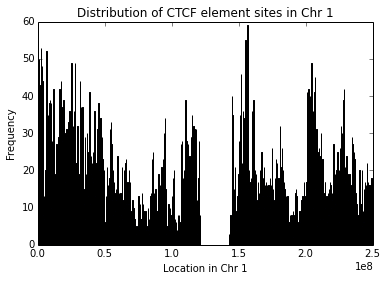

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt

# the histogram of the data
plt.hist(txn_factors[1][np.where(rows_to_take)[0]].tolist(), 1000)

plt.xlabel('Location in Chr 1')
plt.ylabel('Frequency')
plt.title('Distribution of CTCF element sites in Chr 1')

plt.show()

There is a big gaping hole in the middle of the chromosome. What is going on? If you have a little bit of background in biology, you may be able to guess right away.

Let me give you a hint:

https://en.wikipedia.org/wiki/Centromere